Dynamic triple determination for "pairs trading"

In [1]:
# Historical snapshot of coins from December 01, 2019: https://coinmarketcap.com/historical/20191201/ used to
# get a representative set of coins from before the period of analysis to avoid look-ahead bias.

strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

## Load And Structure Data

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
in_sample_end = pd.to_datetime("2022-12-31 20:00:00")
out_sample_start = pd.to_datetime("2023-01-01 00:00:00")

In [4]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [5]:
px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)
# px_data

px_close

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,0.19406,205.64,41.58,NaN,13.8159,0.04515,NaN,0.03308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,0.19358,205.61,41.67,NaN,13.7162,0.04509,NaN,0.03321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,0.19474,206.35,41.79,NaN,13.7270,0.04547,NaN,0.03361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 08:00:00,104762.96,3313.45,3.12950,437.60,122.68,0.7800,684.3800,0.42430,NaN,0.98640,...,0.4710,0.1701,0.5386,0.03753,0.03903,0.06145,NaN,0.667,6.366,255.41
2025-01-26 12:00:00,105041.93,3315.93,3.12040,438.40,122.33,0.7811,684.4300,0.42390,NaN,0.99140,...,0.4720,0.1708,0.5504,0.03920,0.03903,0.06145,NaN,0.667,6.354,254.91
2025-01-26 16:00:00,105020.61,3338.27,3.13290,434.40,121.95,0.8028,683.2200,0.42510,NaN,0.99820,...,0.4716,0.1708,0.5304,0.04240,0.03903,0.05826,NaN,0.723,6.418,256.41


## Determine Dynamic Triples Of Correlated Coins

In [6]:
# dynamic_triples = {px_close.index[0]: []}

# for index_pos in range(1, px_close.shape[0]+1):
#     available_coins = get_available_coins(dynamic_triplesindex_pos, px_close)

coins = px_close.iloc[50].sort_values(ascending=False)[:8].index
coins

Index(['BTCUSDT', 'BCHUSDT', 'ETHUSDT', 'LTCUSDT', 'BNBUSDT', 'NEOUSDT',
       'ETCUSDT', 'ATOMUSDT'],
      dtype='object')

In [7]:
# # SOLUSDT, DOTUSDT

# all_coins = list(coins) + ['SOLUSDT', 'DOTUSDT']
# all_coins

u = px_close.loc[:in_sample_end].corr()['BTCUSDT']
all_coins = list(u[u > 0.8].index)
all_coins

['BTCUSDT',
 'ETHUSDT',
 'LTCUSDT',
 'EOSUSDT',
 'BNBUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'LINKUSDT',
 'ATOMUSDT',
 'MKRUSDT',
 'VETUSDT',
 'BATUSDT',
 'ZECUSDT',
 'SNXUSDT',
 'QTUMUSDT',
 'ZRXUSDT',
 'ALGOUSDT',
 'OMGUSDT',
 'DGBUSDT',
 'LSKUSDT',
 'QNTUSDT',
 'MATICUSDT',
 'ENJUSDT',
 'ZENUSDT',
 'MANAUSDT',
 'LRCUSDT',
 'FTMUSDT',
 'WAXPUSDT',
 'BNTUSDT',
 'DOTUSDT']

In [204]:
px_close[all_coins]

,BTCUSDT,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,41.58,NaN,13.8159,0.04515,0.03308,NaN,4.332,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,41.55,NaN,13.7648,0.04493,0.03320,NaN,4.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,41.67,NaN,13.7162,0.04509,0.03321,NaN,4.335,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,41.89,NaN,13.7958,0.04542,0.03357,NaN,4.378,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,41.79,NaN,13.7270,0.04547,0.03361,NaN,4.454,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,105032.90,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,...,108.4,NaN,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,104970.51,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,...,108.5,NaN,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,104762.96,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,...,105.0,NaN,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [205]:
independent_coins = all_coins[:]
independent_coins.remove('BTCUSDT')
independent_coins

['ETHUSDT',
 'LTCUSDT',
 'EOSUSDT',
 'BNBUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'LINKUSDT',
 'ATOMUSDT',
 'MKRUSDT',
 'VETUSDT',
 'BATUSDT',
 'ZECUSDT',
 'SNXUSDT',
 'QTUMUSDT',
 'ZRXUSDT',
 'ALGOUSDT',
 'OMGUSDT',
 'DGBUSDT',
 'LSKUSDT',
 'QNTUSDT',
 'MATICUSDT',
 'ENJUSDT',
 'ZENUSDT',
 'MANAUSDT',
 'LRCUSDT',
 'FTMUSDT',
 'WAXPUSDT',
 'BNTUSDT',
 'DOTUSDT']

In [206]:
independent_data = px_close[independent_coins][:]
independent_data

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,130.18,41.58,NaN,13.8159,0.04515,0.03308,NaN,4.332,NaN,0.005353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,130.52,41.55,NaN,13.7648,0.04493,0.03320,NaN,4.328,NaN,0.005331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,130.84,41.67,NaN,13.7162,0.04509,0.03321,NaN,4.335,NaN,0.005418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,131.84,41.89,NaN,13.7958,0.04542,0.03357,NaN,4.378,NaN,0.005450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,131.98,41.79,NaN,13.7270,0.04547,0.03361,NaN,4.454,NaN,0.005406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,0.048020,...,108.4,NaN,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,0.048180,...,108.5,NaN,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,0.047460,...,105.0,NaN,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [207]:
independent_data_with_zeroes = independent_data.fillna(0.0)
independent_data_with_zeroes

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,130.18,41.58,0.0000,13.8159,0.04515,0.03308,0.00,4.332,0.0,0.005353,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 04:00:00,130.52,41.55,0.0000,13.7648,0.04493,0.03320,0.00,4.328,0.0,0.005331,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 08:00:00,130.84,41.67,0.0000,13.7162,0.04509,0.03321,0.00,4.335,0.0,0.005418,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 12:00:00,131.84,41.89,0.0000,13.7958,0.04542,0.03357,0.00,4.378,0.0,0.005450,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 16:00:00,131.98,41.79,0.0000,13.7270,0.04547,0.03361,0.00,4.454,0.0,0.005406,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,0.048020,...,108.4,0.0,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,0.048180,...,108.5,0.0,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,0.047460,...,105.0,0.0,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [208]:
import statsmodels.api as sm

independent_data_with_zeroes = sm.add_constant(independent_data_with_zeroes)

In [209]:
independent_data.corrwith(px_close["BTCUSDT"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ETHUSDT      0.846706
LTCUSDT      0.435429
EOSUSDT     -0.186037
BNBUSDT      0.882312
XLMUSDT      0.553711
ADAUSDT      0.492840
LINKUSDT     0.816921
ATOMUSDT     0.273787
MKRUSDT      0.578333
VETUSDT      0.445131
BATUSDT      0.258261
ZECUSDT     -0.079524
SNXUSDT     -0.022750
QTUMUSDT     0.349815
ZRXUSDT      0.416932
ALGOUSDT     0.010603
OMGUSDT      0.736539
DGBUSDT      0.446545
LSKUSDT      0.385700
QNTUSDT     -0.283797
MATICUSDT   -0.254158
ENJUSDT     -0.160651
ZENUSDT      0.166699
MANAUSDT    -0.092275
LRCUSDT     -0.175358
FTMUSDT      0.355834
WAXPUSDT    -0.381155
BNTUSDT      0.311965
DOTUSDT      0.074010
dtype: float64

In [210]:
independent_data_with_zeroes

,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.0,130.18,41.58,0.0000,13.8159,0.04515,0.03308,0.00,4.332,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 04:00:00,1.0,130.52,41.55,0.0000,13.7648,0.04493,0.03320,0.00,4.328,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 08:00:00,1.0,130.84,41.67,0.0000,13.7162,0.04509,0.03321,0.00,4.335,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 12:00:00,1.0,131.84,41.89,0.0000,13.7958,0.04542,0.03357,0.00,4.378,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 16:00:00,1.0,131.98,41.79,0.0000,13.7270,0.04547,0.03361,0.00,4.454,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,1.0,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,...,108.4,0.0,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,1.0,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,...,108.5,0.0,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,1.0,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,...,105.0,0.0,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [211]:
independent_data_with_zeroes[independent_data_with_zeroes.isna()]

,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-26 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
independent_data_with_zeroes

,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.0,130.18,41.58,0.0000,13.8159,0.04515,0.03308,0.00,4.332,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 04:00:00,1.0,130.52,41.55,0.0000,13.7648,0.04493,0.03320,0.00,4.328,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 08:00:00,1.0,130.84,41.67,0.0000,13.7162,0.04509,0.03321,0.00,4.335,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 12:00:00,1.0,131.84,41.89,0.0000,13.7958,0.04542,0.03357,0.00,4.378,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 16:00:00,1.0,131.98,41.79,0.0000,13.7270,0.04547,0.03361,0.00,4.454,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,1.0,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,...,108.4,0.0,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,1.0,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,...,108.5,0.0,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,1.0,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,...,105.0,0.0,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [213]:
independent_data_with_zeroes.loc["2020-06-01 00:00:00"]

const          1.000000
ETHUSDT      238.590000
LTCUSDT       46.240000
EOSUSDT        0.000000
BNBUSDT       17.450100
XLMUSDT        0.072560
ADAUSDT        0.080900
LINKUSDT       0.000000
ATOMUSDT       2.777000
MKRUSDT        0.000000
VETUSDT        0.007264
BATUSDT        0.217100
ZECUSDT        0.000000
SNXUSDT        0.000000
QTUMUSDT       1.793000
ZRXUSDT        0.320500
ALGOUSDT       0.000000
OMGUSDT        0.000000
DGBUSDT        0.000000
LSKUSDT        0.000000
QNTUSDT        0.000000
MATICUSDT      0.000000
ENJUSDT        0.000000
ZENUSDT        0.000000
MANAUSDT       0.000000
LRCUSDT        0.000000
FTMUSDT        0.000000
WAXPUSDT       0.000000
BNTUSDT        0.000000
DOTUSDT        0.000000
Name: 2020-06-01 00:00:00, dtype: float64

In [214]:
px_close.loc["2020-06-01 00:00:00"]["BTCUSDT"]

9550.39

In [215]:
from statsmodels.regression.rolling import RollingOLS

model = RollingOLS(px_close["BTCUSDT"], independent_data_with_zeroes, window=look_back_window_size,
                   min_nobs=look_back_min_periods,
                   expanding=True)

# model = RollingOLS(px_close["BTCUSDT"], independent_data_with_zeroes, window=8, expanding=True)

rolling_result = model.fit(params_only=True)
rolling_result.params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,44372.653015,4.318408,-36.051390,-722.550125,31.210533,-8550.163259,15024.004977,900.737385,-1420.239148,2.767952,...,34.232089,-1794.627945,17433.023040,-45.161919,23135.166288,38372.301735,-3939.516965,18045.777008,710.617935,-5417.581678
2025-01-26 04:00:00,44317.994942,4.362986,-39.772236,-447.041449,31.516247,-8400.404157,14665.349650,896.421492,-1423.948226,2.638160,...,35.643027,-1806.596361,19132.457633,-44.933306,24444.055616,38337.429035,-4060.714171,19677.484603,768.289404,-5355.707851
2025-01-26 08:00:00,45657.322087,4.731400,-39.537813,-252.436281,28.976911,-8505.538874,14223.555497,859.845274,-1682.530363,2.215856,...,44.490841,-1897.486578,23161.520424,-45.580933,24432.796346,38595.796114,-4860.934539,21119.850672,1012.239188,-5176.146288


In [216]:
independent_data_with_zeroes

,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.0,130.18,41.58,0.0000,13.8159,0.04515,0.03308,0.00,4.332,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 04:00:00,1.0,130.52,41.55,0.0000,13.7648,0.04493,0.03320,0.00,4.328,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 08:00:00,1.0,130.84,41.67,0.0000,13.7162,0.04509,0.03321,0.00,4.335,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 12:00:00,1.0,131.84,41.89,0.0000,13.7958,0.04542,0.03357,0.00,4.378,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 16:00:00,1.0,131.98,41.79,0.0000,13.7270,0.04547,0.03361,0.00,4.454,0.0,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,1.0,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,...,108.4,0.0,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,1.0,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,...,108.5,0.0,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,1.0,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,...,105.0,0.0,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [217]:
rolling_result.params.loc["2020-06-01 00:00:00"]

const       NaN
ETHUSDT     NaN
LTCUSDT     NaN
EOSUSDT     NaN
BNBUSDT     NaN
XLMUSDT     NaN
ADAUSDT     NaN
LINKUSDT    NaN
ATOMUSDT    NaN
MKRUSDT     NaN
VETUSDT     NaN
BATUSDT     NaN
ZECUSDT     NaN
SNXUSDT     NaN
QTUMUSDT    NaN
ZRXUSDT     NaN
ALGOUSDT    NaN
OMGUSDT     NaN
DGBUSDT     NaN
LSKUSDT     NaN
QNTUSDT     NaN
MATICUSDT   NaN
ENJUSDT     NaN
ZENUSDT     NaN
MANAUSDT    NaN
LRCUSDT     NaN
FTMUSDT     NaN
WAXPUSDT    NaN
BNTUSDT     NaN
DOTUSDT     NaN
Name: 2020-06-01 00:00:00, dtype: float64

In [218]:
independent_data_with_zeroes.loc["2020-06-01"]

,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,1.0,238.59,46.24,0.0,17.4501,0.07256,0.08090,0.0,2.777,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01 04:00:00,1.0,238.46,46.09,0.0,17.4515,0.07418,0.07848,0.0,2.762,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01 08:00:00,1.0,236.48,45.88,0.0,17.2824,0.07346,0.07733,0.0,2.738,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01 12:00:00,1.0,237.86,46.60,0.0,17.3292,0.07552,0.07937,0.0,2.751,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01 16:00:00,1.0,238.13,47.05,0.0,17.4351,0.07474,0.07929,0.0,2.797,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01 20:00:00,1.0,248.00,48.22,0.0,17.9038,0.07559,0.08092,0.0,2.857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
rolling_result.params[independent_coins].loc["2024-04-01 00:00:00"]

ETHUSDT          10.215515
LTCUSDT          82.841717
EOSUSDT       -1471.661971
BNBUSDT           5.416012
XLMUSDT       22005.726316
ADAUSDT         574.701254
LINKUSDT       -204.168345
ATOMUSDT       -251.812272
MKRUSDT           1.430380
VETUSDT      163463.973366
BATUSDT       13160.111252
ZECUSDT        -177.970858
SNXUSDT         141.311932
QTUMUSDT       1110.637705
ZRXUSDT        3452.266284
ALGOUSDT     -22799.827723
OMGUSDT       14510.104434
DGBUSDT     -166823.961821
LSKUSDT        -188.959261
QNTUSDT          68.414597
MATICUSDT      3402.009823
ENJUSDT        2214.964665
ZENUSDT        -213.331330
MANAUSDT     -10694.823338
LRCUSDT       -7793.689759
FTMUSDT         795.240300
WAXPUSDT      54191.942868
BNTUSDT       -3249.249788
DOTUSDT         588.911955
Name: 2024-04-01 00:00:00, dtype: float64

In [220]:
px_close[independent_coins]

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,130.18,41.58,NaN,13.8159,0.04515,0.03308,NaN,4.332,NaN,0.005353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,130.52,41.55,NaN,13.7648,0.04493,0.03320,NaN,4.328,NaN,0.005331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,130.84,41.67,NaN,13.7162,0.04509,0.03321,NaN,4.335,NaN,0.005418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,131.84,41.89,NaN,13.7958,0.04542,0.03357,NaN,4.378,NaN,0.005450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,131.98,41.79,NaN,13.7270,0.04547,0.03361,NaN,4.454,NaN,0.005406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,0.048020,...,108.4,NaN,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,0.048180,...,108.5,NaN,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,0.047460,...,105.0,NaN,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [221]:
df = pd.DataFrame(0.0, columns=['A', 'B', 'C'], index=[])

s = pd.Series({'A': 1, 'B': 2, 'C': 3})
df.loc[0] = s
df

,A,B,C
0,1,2,3


In [222]:
import statsmodels.api as sm

running_params = pd.DataFrame(0.0, columns=independent_data_with_zeroes.columns, index=[])

for index in range(look_back_window_size, len(independent_data_with_zeroes)):
    dependent_var_data = px_close["BTCUSDT"].iloc[(index-look_back_window_size):index]
    independent_vars_data = independent_data_with_zeroes.iloc[(index-look_back_window_size):index]
    model = sm.OLS(dependent_var_data, independent_vars_data)
    result = model.fit()
    running_params.loc[independent_data_with_zeroes.index[index]] = result.params
    

model = sm.OLS(
    px_close["BTCUSDT"].iloc[0:look_back_window_size],
    independent_data_with_zeroes[0:look_back_window_size])
result = model.fit()

# independent_data_with_zeroes[independent_coins]
# independent_data_with_zeroes
# px_close["BTCUSDT"]

# result.params
# result.summary()
running_params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,const,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
2020-01-31 00:00:00,4062.318047,11.065972,56.999050,5.792417e-08,21.727171,-25070.755293,25981.089016,7.803672e-10,-482.854783,-2.610830e-11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 04:00:00,3983.774502,12.466877,52.058315,-2.424216e-07,16.400245,-24672.936485,26177.105924,-4.337222e-10,-478.526486,-3.011076e-11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 08:00:00,3949.199465,10.961549,50.105163,-1.042905e-07,30.223747,-24600.968053,26964.241552,9.458887e-10,-485.253619,2.973488e-11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 12:00:00,3867.388766,10.228790,47.347834,1.681809e-08,44.166197,-25133.174346,28411.936077,-1.844884e-10,-495.188776,-2.771136e-11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 16:00:00,3774.725042,10.034243,43.683694,-1.868643e-08,50.477709,-25264.146582,29153.856387,-6.380727e-10,-488.726043,4.650650e-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,45833.003601,4.328250,-32.717148,-9.238877e+02,27.309302,-7580.921014,14574.448524,9.071757e+02,-1299.883322,2.608773e+00,...,31.818926,-1805.160930,17260.166746,-36.885548,20424.658334,36060.836895,-4264.797054,27901.026042,542.472510,-5335.747916
2025-01-26 04:00:00,44372.652990,4.318408,-36.051390,-7.225501e+02,31.210533,-8550.163255,15024.004978,9.007374e+02,-1420.239148,2.767952e+00,...,34.232089,-1794.627944,17433.022991,-45.161919,23135.166349,38372.301748,-3939.516959,18045.776999,710.617933,-5417.581678
2025-01-26 08:00:00,44317.994910,4.362986,-39.772236,-4.470414e+02,31.516247,-8400.404165,14665.349656,8.964215e+02,-1423.948226,2.638160e+00,...,35.643027,-1806.596361,19132.457581,-44.933306,24444.055680,38337.429045,-4060.714165,19677.484600,768.289402,-5355.707852
2025-01-26 12:00:00,45657.322062,4.731400,-39.537813,-2.524363e+02,28.976911,-8505.538871,14223.555499,8.598453e+02,-1682.530364,2.215856e+00,...,44.490841,-1897.486578,23161.520374,-45.580933,24432.796403,38595.796120,-4860.934533,21119.850668,1012.239187,-5176.146289


In [223]:
independent_data_with_zeroes[independent_coins]

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,130.18,41.58,0.0000,13.8159,0.04515,0.03308,0.00,4.332,0.0,0.005353,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 04:00:00,130.52,41.55,0.0000,13.7648,0.04493,0.03320,0.00,4.328,0.0,0.005331,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 08:00:00,130.84,41.67,0.0000,13.7162,0.04509,0.03321,0.00,4.335,0.0,0.005418,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 12:00:00,131.84,41.89,0.0000,13.7958,0.04542,0.03357,0.00,4.378,0.0,0.005450,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
2020-01-01 16:00:00,131.98,41.79,0.0000,13.7270,0.04547,0.03361,0.00,4.454,0.0,0.005406,...,0.0,0.0,0.0000,0.00,0.0000,0.0000,0.0000,0.00000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,3341.47,124.16,0.7786,688.6300,0.42130,0.98480,25.60,6.089,1219.0,0.048020,...,108.4,0.0,0.1755,20.28,0.4783,0.1667,0.5369,0.03903,0.667,6.336
2025-01-26 04:00:00,3339.48,123.94,0.7810,687.9400,0.42380,0.99170,25.69,6.081,1247.0,0.048180,...,108.5,0.0,0.1725,19.55,0.4746,0.1682,0.5505,0.03903,0.667,6.348
2025-01-26 08:00:00,3313.45,122.68,0.7800,684.3800,0.42430,0.98640,25.27,6.097,1228.0,0.047460,...,105.0,0.0,0.1725,19.78,0.4710,0.1701,0.5386,0.03903,0.667,6.366


In [224]:
running_params[independent_coins]

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
2020-01-31 00:00:00,11.065972,56.999050,5.792417e-08,21.727171,-25070.755293,25981.089016,7.803672e-10,-482.854783,-2.610830e-11,238358.145967,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 04:00:00,12.466877,52.058315,-2.424216e-07,16.400245,-24672.936485,26177.105924,-4.337222e-10,-478.526486,-3.011076e-11,244302.887614,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 08:00:00,10.961549,50.105163,-1.042905e-07,30.223747,-24600.968053,26964.241552,9.458887e-10,-485.253619,2.973488e-11,256998.787275,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 12:00:00,10.228790,47.347834,1.681809e-08,44.166197,-25133.174346,28411.936077,-1.844884e-10,-495.188776,-2.771136e-11,285421.550048,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-31 16:00:00,10.034243,43.683694,-1.868643e-08,50.477709,-25264.146582,29153.856387,-6.380727e-10,-488.726043,4.650650e-12,296162.531187,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,4.328250,-32.717148,-9.238877e+02,27.309302,-7580.921014,14574.448524,9.071757e+02,-1299.883322,2.608773e+00,397884.928142,...,31.818926,-1805.160930,17260.166746,-36.885548,20424.658334,36060.836895,-4264.797054,27901.026042,542.472510,-5335.747916
2025-01-26 04:00:00,4.318408,-36.051390,-7.225501e+02,31.210533,-8550.163255,15024.004978,9.007374e+02,-1420.239148,2.767952e+00,385844.993535,...,34.232089,-1794.627944,17433.022991,-45.161919,23135.166349,38372.301748,-3939.516959,18045.776999,710.617933,-5417.581678
2025-01-26 08:00:00,4.362986,-39.772236,-4.470414e+02,31.516247,-8400.404165,14665.349656,8.964215e+02,-1423.948226,2.638160e+00,387818.121559,...,35.643027,-1806.596361,19132.457581,-44.933306,24444.055680,38337.429045,-4060.714165,19677.484600,768.289402,-5355.707852
2025-01-26 12:00:00,4.731400,-39.537813,-2.524363e+02,28.976911,-8505.538871,14223.555499,8.598453e+02,-1682.530364,2.215856e+00,392342.389850,...,44.490841,-1897.486578,23161.520374,-45.580933,24432.796403,38595.796120,-4860.934533,21119.850668,1012.239187,-5176.146289


In [225]:
# estimates = (rolling_result.params[independent_coins] * independent_data_with_zeroes[independent_coins]).sum(axis=1) + rolling_result.params["const"]
# estimates

estimates = (running_params[independent_coins] * independent_data_with_zeroes[independent_coins]).sum(axis=1) + running_params["const"]
estimates

2020-01-01 00:00:00              NaN
2020-01-01 04:00:00              NaN
2020-01-01 08:00:00              NaN
2020-01-01 12:00:00              NaN
2020-01-01 16:00:00              NaN
                           ...      
2025-01-26 00:00:00    105406.197479
2025-01-26 04:00:00    105543.805818
2025-01-26 08:00:00    104237.708287
2025-01-26 12:00:00    104349.424083
2025-01-26 16:00:00    103348.258808
Length: 11111, dtype: float64

<Axes: xlabel='datetime'>

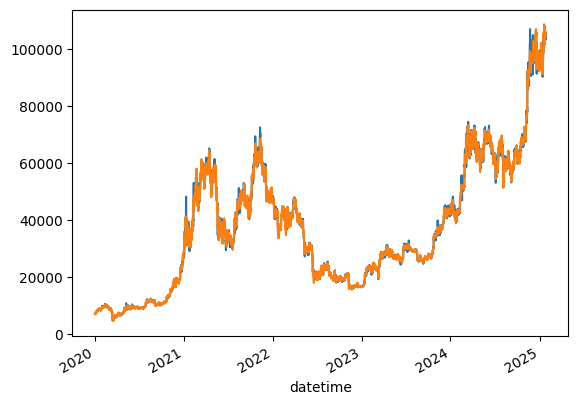

In [226]:
estimates.plot()
px_close["BTCUSDT"].plot()

In [227]:
residuals = px_close["BTCUSDT"] - estimates
residuals

datetime
2020-01-01 00:00:00            NaN
2020-01-01 04:00:00            NaN
2020-01-01 08:00:00            NaN
2020-01-01 12:00:00            NaN
2020-01-01 16:00:00            NaN
                          ...     
2025-01-26 00:00:00    -373.297479
2025-01-26 04:00:00    -573.295818
2025-01-26 08:00:00     525.251713
2025-01-26 12:00:00     692.505917
2025-01-26 16:00:00    1688.701192
Length: 11111, dtype: float64

In [228]:
spread_data = {"residuals": residuals}

rolling_mean = residuals.rolling(window=look_back_window_size, min_periods=look_back_min_periods).mean()
spread_data["rolling mean"] = rolling_mean
rolling_mean

datetime
2020-01-01 00:00:00          NaN
2020-01-01 04:00:00          NaN
2020-01-01 08:00:00          NaN
2020-01-01 12:00:00          NaN
2020-01-01 16:00:00          NaN
                         ...    
2025-01-26 00:00:00   -70.690221
2025-01-26 04:00:00   -73.897546
2025-01-26 08:00:00   -70.725322
2025-01-26 12:00:00   -64.360024
2025-01-26 16:00:00   -53.217386
Length: 11111, dtype: float64

In [229]:
rolling_std = residuals.rolling(window=look_back_window_size, min_periods=look_back_min_periods).std()
spread_data["rolling_std"] = rolling_std
rolling_std

datetime
2020-01-01 00:00:00            NaN
2020-01-01 04:00:00            NaN
2020-01-01 08:00:00            NaN
2020-01-01 12:00:00            NaN
2020-01-01 16:00:00            NaN
                          ...     
2025-01-26 00:00:00    1213.690819
2025-01-26 04:00:00    1214.254964
2025-01-26 08:00:00    1215.074502
2025-01-26 12:00:00    1216.060100
2025-01-26 16:00:00    1222.902147
Length: 11111, dtype: float64

In [230]:
z_scores = (residuals - rolling_mean) / rolling_std
spread_data["z_scores"] = z_scores
z_scores

datetime
2020-01-01 00:00:00         NaN
2020-01-01 04:00:00         NaN
2020-01-01 08:00:00         NaN
2020-01-01 12:00:00         NaN
2020-01-01 16:00:00         NaN
                         ...   
2025-01-26 00:00:00   -0.249328
2025-01-26 04:00:00   -0.411280
2025-01-26 08:00:00    0.490486
2025-01-26 12:00:00    0.622392
2025-01-26 16:00:00    1.424414
Length: 11111, dtype: float64

In [231]:
# z_scores[z_scores.notna()]
# residuals[residuals.notna()]
estimates[estimates.notna()]

2020-01-31 00:00:00      9807.671227
2020-01-31 04:00:00      9643.288929
2020-01-31 08:00:00      9664.586529
2020-01-31 12:00:00      9611.334788
2020-01-31 16:00:00      9556.120661
                           ...      
2025-01-26 00:00:00    105406.197479
2025-01-26 04:00:00    105543.805818
2025-01-26 08:00:00    104237.708287
2025-01-26 12:00:00    104349.424083
2025-01-26 16:00:00    103348.258808
Length: 10931, dtype: float64

In [232]:
spread_data = pd.DataFrame(spread_data)
spread_data

,residuals,rolling mean,rolling_std,z_scores
datetime,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-01-26 00:00:00,-373.297479,-70.690221,1213.690819,-0.249328
2025-01-26 04:00:00,-573.295818,-73.897546,1214.254964,-0.411280
2025-01-26 08:00:00,525.251713,-70.725322,1215.074502,0.490486


In [233]:
z_scores[z_scores.abs() > 1.0]

datetime
2020-02-10 00:00:00    1.477442
2020-02-11 00:00:00   -1.012620
2020-02-11 12:00:00    1.204857
2020-02-12 16:00:00   -1.148810
2020-02-15 04:00:00    1.346218
                         ...   
2025-01-24 20:00:00    1.068682
2025-01-25 00:00:00    1.153507
2025-01-25 12:00:00    1.130090
2025-01-25 16:00:00    1.049016
2025-01-26 16:00:00    1.424414
Length: 3226, dtype: float64

In [242]:
threshold = 2.0

def get_holdings_for_strategy_A(px_close, threshold, z_scores, independent_coins, running_params):
    holdings_df = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

    hi_z_scores = z_scores[z_scores > threshold]
    lo_z_scores = z_scores[z_scores < -threshold]

    holdings_df.loc[hi_z_scores.index, "BTCUSDT"] = -1.0
    holdings_df.loc[hi_z_scores.index, independent_coins] = running_params.loc[hi_z_scores.index, independent_coins]

    holdings_df.loc[lo_z_scores.index, "BTCUSDT"] = 1.0
    holdings_df.loc[lo_z_scores.index, independent_coins] = -running_params.loc[lo_z_scores.index, independent_coins]

    holdings_df = holdings_df.shift()
    holdings_df = holdings_df.divide(holdings_df.abs().sum(axis=1), axis=0)
    holdings_df.fillna(0.0, inplace=True)
    return holdings_df

# holdings_df_A = get_holdings_for_strategy_A(px_close, threshold, z_scores, independent_coins, rolling_result.params)
holdings_df_A = get_holdings_for_strategy_A(px_close, threshold, z_scores, independent_coins, running_params)
holdings_df_A

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-26 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-26 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
rolling_result.params.loc[z_scores[z_scores > 1.0].index, independent_coins]

,ETHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,ADAUSDT,LINKUSDT,ATOMUSDT,MKRUSDT,VETUSDT,...,QNTUSDT,MATICUSDT,ENJUSDT,ZENUSDT,MANAUSDT,LRCUSDT,FTMUSDT,WAXPUSDT,BNTUSDT,DOTUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-11 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-15 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-15 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24 20:00:00,3.769136,-81.959365,932.365302,29.261784,-5976.579226,15283.181675,1016.165460,-1298.744195,3.956976,422143.177094,...,3.438501,-1750.194661,-1742.518770,-32.831346,19111.352051,48658.537539,-813.802611,22117.096612,1429.101606,-5107.862235
2025-01-25 00:00:00,3.637209,-72.576947,-54.003564,26.574869,-6704.243282,15548.533918,996.560825,-1161.364065,3.498802,424287.933510,...,12.127997,-1735.981968,8359.770119,-22.725586,20913.346820,47433.070710,-1613.610534,27209.006103,1246.898462,-5363.015649
2025-01-25 12:00:00,4.022411,-45.904886,-820.385758,23.247167,-5854.494763,15184.051645,939.708191,-1204.431068,2.747153,415470.770710,...,24.563877,-1897.191140,15838.029838,-11.524593,19229.799864,41767.817720,-3997.360813,27454.739416,852.011808,-5265.639424


In [244]:
holdings_df_A.loc["2021-12-12"]

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-12 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias.
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

<Axes: xlabel='datetime'>

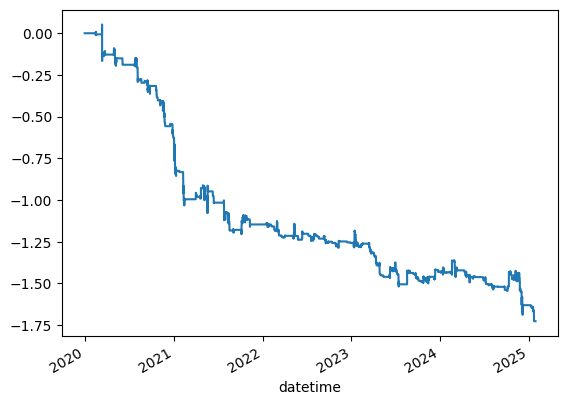

In [246]:
close_price_returns = px_close / px_close.shift() - 1
get_net_return(holdings_df_A, close_price_returns).cumsum().plot()

In [239]:
from enum import Enum
import math

threshold = 3.0

holdings_df_B = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

class ZScoreType(Enum):
    HI_Z_SCORE = 1
    LO_Z_SCORE = 2
    MID_Z_SCORE = 3

z_score_type = ZScoreType.MID_Z_SCORE
    
for datetime_point in px_close.index:
    curr_z_score = z_scores.loc[datetime_point]
    if not math.isnan(curr_z_score):
        if curr_z_score > threshold or (z_score_type == ZScoreType.HI_Z_SCORE and curr_z_score > 0.0):
            holdings_df_B.loc[datetime_point, "BTCUSDT"] = -1.0
            holdings_df_B.loc[datetime_point, independent_coins] = \
                running_params.loc[datetime_point, independent_coins]
                #rolling_result.params.loc[datetime_point, independent_coins]
            z_score_type = ZScoreType.HI_Z_SCORE
        elif curr_z_score < -threshold or (z_score_type == ZScoreType.LO_Z_SCORE and curr_z_score < 0.0):
            holdings_df_B.loc[datetime_point, "BTCUSDT"] = 1.0
            holdings_df_B.loc[datetime_point, independent_coins] = \
                -running_params.loc[datetime_point, independent_coins]
                #-rolling_result.params.loc[datetime_point, independent_coins]
            z_score_type = ZScoreType.LO_Z_SCORE
        elif curr_z_score > 0.0 and z_score_type == ZScoreType.LO_Z_SCORE:
            z_score_type = ZScoreType.MID_Z_SCORE
        elif curr_z_score < 0.0 and z_score_type == ZScoreType.HI_Z_SCORE:
            z_score_type = ZScoreType.MID_Z_SCORE
        
holdings_df_B = holdings_df_B.divide(holdings_df_B.abs().sum(axis=1), axis=0)
holdings_df_B = holdings_df_B.shift()
holdings_df_B.fillna(0.0, inplace=True)

holdings_df_B[holdings_df_B["BTCUSDT"] > 0.0]

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-12 12:00:00,9.982163e-06,-0.000033,0.0,0.0,-0.000400,-5.679707e-12,-0.001516,0.075661,0.0,-0.052577,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,0.0,0.0,-0.000000,-0.000000,0.0
2020-03-12 16:00:00,1.000917e-05,-0.000045,0.0,0.0,-0.000377,-1.740853e-12,-0.001680,0.093093,0.0,0.032133,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,0.0,0.0,-0.000000,-0.000000,0.0
2020-03-12 20:00:00,1.649989e-05,-0.000106,0.0,0.0,-0.000523,9.623155e-13,-0.002668,0.213381,0.0,0.074403,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,0.0,0.0,-0.000000,-0.000000,0.0
2020-03-13 00:00:00,3.210327e-05,-0.000263,0.0,0.0,-0.000815,-1.037656e-13,-0.005024,0.532793,0.0,0.024179,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,0.0,0.0,-0.000000,-0.000000,0.0
2020-03-13 04:00:00,1.678359e-05,-0.000210,0.0,0.0,-0.000107,-1.213812e-13,-0.002584,0.421840,0.0,-0.217967,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,0.0,0.0,-0.000000,-0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-19 16:00:00,1.100303e-06,-0.000012,0.0,0.0,0.000140,2.618030e-03,-0.000012,0.003998,0.0,-0.019631,...,-0.030959,0.024586,0.002575,0.0,0.030596,0.0,0.0,-0.007660,0.002887,0.0
2025-01-19 20:00:00,1.064919e-06,-0.000010,0.0,0.0,0.000126,2.875524e-03,-0.000016,0.006512,0.0,-0.021492,...,-0.028739,0.016348,0.000410,0.0,0.024858,0.0,0.0,-0.007657,0.002926,0.0
2025-01-20 00:00:00,1.054335e-06,-0.000009,0.0,0.0,0.000121,1.937918e-03,-0.000017,0.007350,0.0,-0.022027,...,-0.028809,0.014765,-0.000155,0.0,0.023022,0.0,0.0,-0.007231,0.002581,0.0


<Axes: xlabel='datetime'>

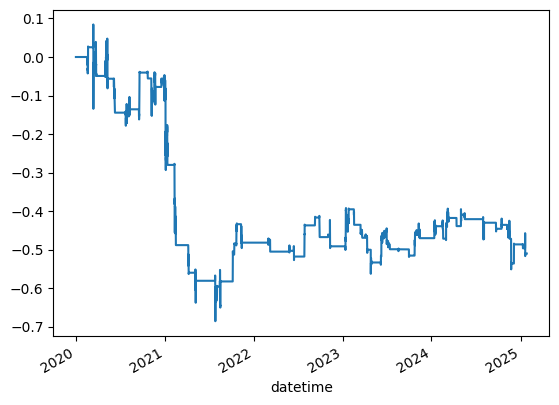

In [240]:
get_net_return(holdings_df_B, close_price_returns).cumsum().plot()

In [241]:
import numpy as np

nr_df = get_net_return(holdings_df_B, close_price_returns)
nr_df.mean() / nr_df.std() * np.sqrt(365 * 6)

-0.42170175499706997

## Pick triples based on previous 30 days of data

In [10]:
holdings_df = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

# look_back_window_size = 30 * 6
# look_back_min_periods = 10 * 6

def has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple):
    pass

current_correlated_triples = dict()
coins_in_a_triple = set()

for index in range(look_back_min_periods, len(holdings_df)):
    px_close_window = px_close[max(index-look_back_window_size, 0):index]
    
    #####
    corr_matrix = px_close_window.corr()
    newly_uncorrelated_keys = set()
    for key_coin, (value_coin_1, value_coin_2) in current_correlated_triples.items():
        if corr_matrix[key_coin, value_coin_1] < 0.9 or corr_matrix[key_coin, value_coin_2] < 0.9:
            newly_uncorrelated_keys.add(key_coin)
    for coin in newly_uncorrelated_keys:
        coins_in_a_triple.remove(coin)
        coins_in_a_triple.remove(current_correlated_triples[coin][0])
        coins_in_a_triple.remove(current_correlated_triples[coin][1])
        del current_correlated_triples[coin]
    for coin in holdings_df.columns:
        if coin not in coins_in_a_triple and has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple):
            pass
    #####

holdings_df

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-26 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-26 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
